## Prelim Prep/Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [10]:
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")

In [11]:
# Using the Pandas bdate_range function, we calculate number of days taken to complete order (excluding weekends)
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

# Drop null values
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

# Drop dates before 2016
orders = df[df['Confirmation Start Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df = df[~df['Order'].isin(orders)]

df.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [12]:
#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

display(df.shape)
display(df.head())

(31961, 17)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [13]:
# Get rid of negative durations
df = df[df['dur']>0]
# Set indices
df.set_index("Confirmation Start Date", inplace = True)
df["month"] = df.index.to_period("M")

## Grouping
Groups based on the assumption that the hierarchy is category -> group -> material from least precise to most precise. Starts by determining all possible groupings of material that have enough data to make a forecast, then moves to group, and finally to category. This information is stored in dictionaries mat_trend, group_trend, cat_trend. To access these items easier the lists mats, groups and cats are created which have the names of all the materials, groups and categories within the respective dictionaries. For example mat_trend[mats[0]] would access the first item within the mat_trend dictionary.

In [14]:
import copy
types = ['Material', 'Group', 'MaterialCategory']
dics = {'mat_trend' : {}, 'group_trend' : {}, 'cat_trend' : {}}
thresholds = [75,75,50]


for (typ, dic, thresh) in zip(types, dics, thresholds):
    # Group 
    gr = df.groupby(typ)
    groups = dict(list(gr))
    # Checks if group has enough data
    for x in groups:
        single = groups[x]
        if len(single) > thresh:
            dics[dic][x] = single

# Transfer back over for ease later            
mat_trend = dics['mat_trend']
group_trend = dics['group_trend']
cat_trend = dics['cat_trend']

# Lists of keys
mats = list(mat_trend.keys())
groups = list(group_trend.keys())
cats = list(cat_trend.keys())

# Note to self: 48, 42, 11
print("Material groups that have enough data: %d" % len(mat_trend))
print("Group groups that have enough data: %d" % len(group_trend))
print("Category groups that have enough data: %d" % len(cat_trend))

Material groups that have enough data: 48
Group groups that have enough data: 41
Category groups that have enough data: 11


## Get Rid of Outliers
Groupings from previous cell taken and trimmed to get rid of outliers. New groupings are put into mat_trend_trim, group_trend_trim, cat_trend_trim

In [ ]:
nam = mats[5]
display(mat_trend[nam].hist(column = 'actual_duration_nowkend'))
display(mat_trend_trim[nam].hist(column = 'actual_duration_nowkend'))

In [15]:
# Returns group with outliers removed using specified method. Args:
# Group: data fed in
# Time: ('total') Want to remove outliers from total df, or ('month') remove outliers per month
# Method: specify iqr or z-score method
def remove_outliers(group, time, method):
    updated_group = pd.DataFrame() 
    if(time == 'month'):
        dates = pd.unique(group["month"])
        for month in dates:
            df_quarter = group.loc[group["month"] == month]
            if method == 'zscore':
                df_quarter['zscore'] = np.abs(stats.zscore(df_quarter['actual_duration_nowkend']))
                temp = df_quarter.loc[df_quarter['zscore'] < 3]
            elif method == 'iqr':
                q1 = df_quarter.quantile(0.25)['actual_duration_nowkend']
                q2 = df_quarter.quantile(0.50)['actual_duration_nowkend']
                q3 = df_quarter.quantile(0.75)['actual_duration_nowkend']

                IQR = q3 - q1
                lower = q1 - 1.5*IQR
                upper = q3 + 1.5*IQR

                # Removes outliers
                temp = df_quarter[(df_quarter['actual_duration_nowkend'] < upper) & (df_quarter['actual_duration_nowkend'] > lower)]
            updated_group = updated_group.append(temp)   
        updated_group = updated_group.sort_values(by='Usage Decision Date')
        return updated_group
    elif(time == 'total'):
        if method == 'zscore':
            group['zscore'] = np.abs(stats.zscore(group['actual_duration_nowkend']))
            group = group[group['zscore'] < 3]
            group.sort_values(by='Usage Decision Date')
            return group
        elif method == 'iqr':
            q1 = group.quantile(0.25)['actual_duration_nowkend']
            q2 = group.quantile(0.50)['actual_duration_nowkend']
            q3 = group.quantile(0.75)['actual_duration_nowkend']

            IQR = q3 - q1
            lower = q1 - 1.5*IQR
            upper = q3 + 1.5*IQR

            # Removes outliers
            group = group[(group['actual_duration_nowkend'] < upper) & (group['actual_duration_nowkend'] > lower)]
            return group

    

In [16]:
lists = [mats, groups, cats]
dics = [mat_trend, group_trend, cat_trend]
types = ['Material', 'Group', 'MaterialCategory']

# new dictionaries to copy over data without outliers
mat_trend_trim = {}
group_trend_trim = {}
cat_trend_trim = {}
new_dics = [mat_trend_trim, group_trend_trim, cat_trend_trim]


# Track amount of datapoints deleted
deltas = []
for (typ, lis, olddic, newdic) in zip(types, lists, dics, new_dics):
    delta = []
    for x in lis:
        group = olddic[x]
        start = len(group)
        # Get rid of outliers - first does overall iqr then does moving iqr
        # group = remove_outliers(group, 'total', 'iqr')
        group = remove_outliers(group, 'month', 'iqr')
        # calculate datapoints lost
        end = len(group)
        delta.append([x, start, end, start-end, (100*(start-end)/start)])
        # Combine all datapoints in same month for consistent frequency
        group_resample = group.resample("M").mean()
        group_resample["actual_duration_nowkend"] = group_resample["actual_duration_nowkend"].fillna(method = "ffill")
        newdic[x] = group_resample
    #append to overall list    
    deltas.append(pd.DataFrame(delta, columns=[typ, 'Start', 'End', 'Delta', 'Percentlost']))

# Updates lists of keys
mats_trim = list(mat_trend_trim.keys())
groups_trim = list(group_trend_trim.keys())
cats_trim = list(cat_trend_trim.keys())
    

In [18]:
# Shows data loss with outlier method 
# 0 = Materials, 1 = Group, 2 = MaterialCategory
print('Materials outlier mean data percent lost: %0.2f' % deltas[0]['Percentlost'].mean())
print('Groups outlier mean data percent lost: %0.2f' % deltas[1]['Percentlost'].mean())
print('MaterialCategory outlier mean data percent lost: %0.2f' % deltas[2]['Percentlost'].mean())

#Results: 

# For moving IQR: 
# Materials outlier mean data percent lost: 12.67
# Groups outlier mean data percent lost: 10.56
# MaterialCategory outlier mean data percent lost: 9.13

#For moving z-score of 3:
# Materials outlier mean data percent lost: 8.03
# Groups outlier mean data percent lost: 5.00
# MaterialCategory outlier mean data percent lost: 3.31

Materials outlier mean data percent lost: 13.98
Groups outlier mean data percent lost: 11.52
MaterialCategory outlier mean data percent lost: 10.44


In [ ]:
# See data loss for different materials
# 0 = Materials, 1 = Group, 2 = MaterialCategory
deltas[0].sort_values(by = 'End')

In [11]:
# Stops run all
assert False

AssertionError: 

## ARIMA MODELING

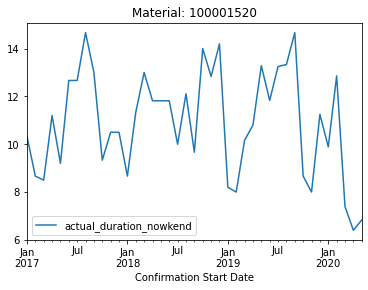

In [19]:
#Taking random group to test ARIMA models on
# 100001520
name = 100001520
sub = mat_trend_trim[name]
sub.plot(y = 'actual_duration_nowkend', title = "Material: %d" % name)

In [20]:
# Time-series data for model
ts = pd.Series(sub['actual_duration_nowkend'].values, index = sub.index)

In [21]:
# Array of external variables
exog_df = pd.DataFrame(sub['Total order quantity'])

# Filling in null values in data 
exog_df = exog_df.fillna(method = "ffill")

# Convert to values for arima model
exog_arr = exog_df.values

In [22]:
# Splitting data into test/train
ratio = 0.8
length = ts.shape[0]
pivot = int(ratio * length)
endpivot = length - pivot

ts_train = ts[:pivot]
ts_test = ts[pivot:]

exog_train = exog_arr[:pivot]
exog_test = exog_arr[pivot:]

dates_train = ts[:pivot]
dates_test = ts[pivot:]

# Just visualizing data
# dfmod = ts_train.to_frame()
# dfmod.reset_index(inplace=True)
# dfmod.columns = ['date','dur']
# dfmod.plot(kind = 'scatter', x='date',y='dur')
# plt.show() 

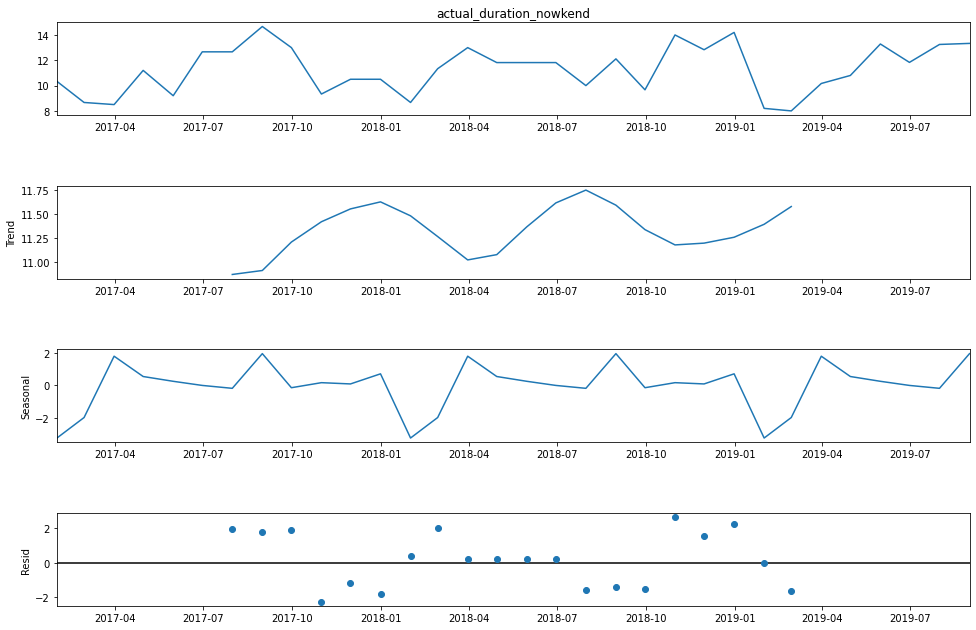

In [23]:
res = sm.tsa.seasonal_decompose(sub["actual_duration_nowkend"][:pivot], model = "additive")
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

In [ ]:
arima = pm.auto_arima

In [24]:
# Fitting
arima = pm.auto_arima(ts_train, exog_train, m=12, D=1, seasonal=True, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)
arima2 = pm.auto_arima(ts_train, exog_train, d=1, error_action='ignore', suppress_warnings = True)
arima3 = pm.auto_arima(ts_train, seasonal=True, error_action='ignore', suppress_warnings = True)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,12) [intercept=True]; AIC=86.821, BIC=95.782, Time=1.534 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=99.823, BIC=102.810, Time=0.094 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=99.685, BIC=104.663, Time=0.492 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=100.275, BIC=105.254, Time=0.475 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=97.878, BIC=99.869, Time=0.040 seconds
Fit ARIMA(2,0,2)x(0,1,1,12) [intercept=True]; AIC=84.871, BIC=92.837, Time=0.883 seconds
Near non-invertible roots for order (2, 0, 2)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA(2,0,2)x(1,1,0,12) [intercept=True]; AIC=85.018, BIC=92.984, Time=0.658 seconds
Near non-in

In [86]:
display(arima.summary())
display(arima2.summary())
display(arima3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   32
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 12)   Log Likelihood                 -35.579
Date:                             Tue, 07 Jul 2020   AIC                             87.158
Time:                                     15:40:47   BIC                             95.124
Sample:                                          0   HQIC                            88.713
                                              - 32                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0046      0.955      1.052      0.293      -0.867       2.876
const          1.1003      1.049      1.049      0.294      -0.955       3.156
ar.L1          1.3892      0.838      1.658      0.097      -0.253       3.031
ar.L2         -0.7370      0.534     -1.381      0.167      -1.783       0.309
ma.L1         -1.8636      8.808     -0.212      0.832     -19.127      15.400
ma.L2          0.8832      7.332      0.120      0.904     -13.488      15.254
ar.S.L12      -0.6788      0.187     -3.622      0.000      -1.046      -0.311
sigma2         1.0819     10.653      0.102      0.919     -19.797      21.961
===================================================================================
Ljung-Box (Q):                       14.76   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.74   Prob(JB):                         0.78
Heteroskedasticity (H):               1.89   Skew:                             0.38
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -60.497
Date:                Tue, 07 Jul 2020   AIC                            134.993
Time:                        15:40:47   BIC                            145.031
Sample:                             0   HQIC                           138.265
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1004      0.038      2.660      0.008       0.026       0.174
const          0.5462      0.629      0.869      0.385      -0.686       1.779
ar.L1          0.9224      0.173      5.332      0.000       0.583       1.261
ar.L2         -0.5599      0.209     -2.678      0.007      -0.970      -0.150
ma.L1         -1.9795      7.061     -0.280      0.779     -15.819      11.860
ma.L2          0.9910      7.015      0.141      0.888     -12.758      14.740
sigma2         2.1649     15.291      0.142      0.887     -27.804      32.134
===================================================================================
Ljung-Box (Q):                       21.39   Jarque-Bera (JB):                 1.41
Prob(Q):                              0.88   Prob(JB):                         0.49
Heteroskedasticity (H):               0.55   Skew:                            -0.15
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -61.025
Date:                Tue, 07 Jul 2020   AIC                            134.051
Time:                        15:40:47   BIC                            142.655
Sample:                             0   HQIC                           136.855
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1014      0.045      2.244      0.025       0.013       0.190
ar.L1          0.9135      0.192      4.754      0.000       0.537       1.290
ar.L2         -0.5365      0.236     -2.270      0.023      -1.000      -0.073
ma.L1         -1.9729     21.727     -0.091      0.928     -44.557      40.611
ma.L2          0.9755     21.144      0.046      0.963     -40.467      42.418
sigma2         2.2070     48.119      0.046      0.963     -92.104      96.518
===================================================================================
Ljung-Box (Q):                       19.20   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.94   Prob(JB):                         0.53
Heteroskedasticity (H):               0.53   Skew:                            -0.03
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
arima.fit(ts_train, exog_train)
arima2.fit(ts_train, exog_train)
arima3.fit(ts_train)

ARIMA(order=(2, 1, 2), suppress_warnings=True)

In [7]:
num_test = ts_test.shape[0]
# forecasts
forecasts = arima.predict(n_periods = length, exogenous = exog_arr)  # predict 
forecasts2 = arima2.predict(n_periods = num_test, exogenous = exog_test)
forecasts3 = arima3.predict(n_periods = num_test)
# Visualize the forecasts (blue=train, green=test)
x = np.arange(length)
plt.plot(x[:pivot], ts, c='blue')
plt.plot(x[pivot:], ts_test, c = 'green')
plt.plot(x[:], forecasts, c='red')
plt.plot(x[pivot:], forecasts2, c='yellow')
plt.plot(x[pivot:], forecasts3, c='magenta')
plt.gcf().set_size_inches(15, 12)
plt.title('Duration vs. Date')
plt.show()


NameError: name 'ts_test' is not defined

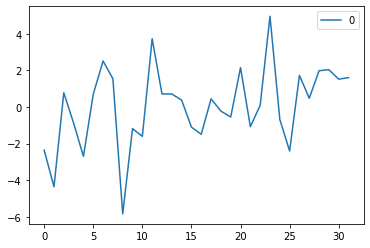

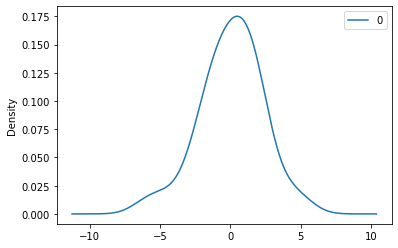

               0
count  32.000000
mean    0.053007
std     2.217032
min    -5.841622
25%    -1.118167
50%     0.413804
75%     1.562269
max     4.962618


In [83]:
residuals = pd.DataFrame(arima.resid())
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [84]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(ts, forecasts)
error2 = mean_squared_error(ts_test, forecasts2)
error3 = mean_squared_error(ts_test, forecasts3)
print('Test MSE: %.3f' % error)
print('Test2 MSE: %.3f' % error2)
print('Test3 MSE: %.3f' % error3)

Test MSE: 7.610
Test2 MSE: 23.095
Test3 MSE: 24.065
